# Сonvolutional network with attention and positional encoding
В данной сети мы используем для энкодера и декодера сверточные одномерные слои с attention механизмом и механизмом кодирования позиции.



In [ ]:
!pip install torchtext==0.11.0
!pip  install subword-nmt
!pip install wget

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import tqdm
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import pickle

import sys
path_to_save_artifacts = '/content/drive/MyDrive/Made_nlp_hw/Made_NLP/conv_network'
sys.path.append(path_to_save_artifacts)
from data_preparation import DataPreparation
import conv_model
import utils_for_conv

### Prepare data

In [ ]:
dataclass = DataPreparation()
train_data, valid_data, test_data = dataclass.data_pipeline()

download data
Dataset not found locally. Downloading from github.
creating dataset
create train, valid and test data
Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
build vocab
Unique tokens in source (ru) vocabulary: 9254
Unique tokens in target (en) vocabulary: 6713


### Create model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
INPUT_DIM = len(dataclass.SRC.vocab)
OUTPUT_DIM = len(dataclass.TRG.vocab)
TRG_PAD_IDX = dataclass.TRG.vocab.stoi[dataclass.TRG.pad_token]

model = conv_model.prepare_model(device, INPUT_DIM, OUTPUT_DIM, TRG_PAD_IDX)

In [ ]:
TRG_PAD_IDX = dataclass.TRG.vocab.stoi[dataclass.TRG.pad_token]

lr = 1e-3
PAD_IDX = dataclass.TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


### Train model

In [ ]:
N_EPOCHS = 20
CLIP = 1
train_history = []
valid_history = []
bleu_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
        
    train_loss = utils_for_conv.train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss, bleu = utils_for_conv.evaluate(model, valid_iterator, criterion, dataclass.TRG.vocab)    

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_history.append(bleu)
    history_dict = {'bleu': bleu_history, 'train': train_history, 'valid': valid_history}
    with open( path_to_save_artifacts + '/model_results.pkl', 'wb') as f:
      pickle.dump(history_dict, f)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_to_save_artifacts + '/conv.pt') 
    print(f'epoch: {epoch}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | lr: {optimizer.param_groups[0]["lr"]}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | val. bleu: {bleu}')
    if epoch!=0:
      if epoch % 5 == 0:
        scheduler.step()
      else:
        pass

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 4.078 | Train PPL:  59.037 | lr: 0.001
	 Val. Loss: 2.710 |  Val. PPL:  15.030 | val. bleu: 15.28039344585324


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 2.693 | Train PPL:  14.777 | lr: 0.001
	 Val. Loss: 2.167 |  Val. PPL:   8.734 | val. bleu: 24.92201865293066


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 2.258 | Train PPL:   9.568 | lr: 0.001
	 Val. Loss: 1.891 |  Val. PPL:   6.629 | val. bleu: 31.189592238547277


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 1.984 | Train PPL:   7.270 | lr: 0.001
	 Val. Loss: 1.748 |  Val. PPL:   5.742 | val. bleu: 34.10089685700856


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 1.778 | Train PPL:   5.920 | lr: 0.001
	 Val. Loss: 1.639 |  Val. PPL:   5.151 | val. bleu: 36.468355376342174


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 1.496 | Train PPL:   4.466 | lr: 0.0001
	 Val. Loss: 1.544 |  Val. PPL:   4.682 | val. bleu: 39.4000081499315


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 1.427 | Train PPL:   4.168 | lr: 0.0001
	 Val. Loss: 1.525 |  Val. PPL:   4.594 | val. bleu: 39.78113875420684


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 1.390 | Train PPL:   4.016 | lr: 0.0001
	 Val. Loss: 1.514 |  Val. PPL:   4.545 | val. bleu: 40.3581932426477


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 1.363 | Train PPL:   3.909 | lr: 0.0001
	 Val. Loss: 1.504 |  Val. PPL:   4.499 | val. bleu: 40.457636605141914


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

	Train Loss: 1.322 | Train PPL:   3.749 | lr: 1e-05
	 Val. Loss: 1.503 |  Val. PPL:   4.496 | val. bleu: 40.56635818838466


  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Load best model

In [ ]:
best_model = conv_model.prepare_model(device, INPUT_DIM, OUTPUT_DIM, TRG_PAD_IDX)
best_model.load_state_dict(torch.load(path_to_save_artifacts + '/conv.pt'))
best_model.eval()

## Check quality of network

In [ ]:
losses, originals, generated_text = utils_for_conv.bad_and_good_translations(best_model, test_iterator, criterion, dataclass.TRG.vocab)

  0%|          | 0/59 [00:00<?, ?it/s]

Best translations

In [ ]:
idx_of_good = np.argsort(losses)
print('Good translation:')
for i in range(3):
  print('Original: {}'.format(' '.join(originals[idx_of_good[i]])))
  print('Generated: {}'.format(' '.join(generated_text[idx_of_good[i]])))

Good translation:
Original: you will find a 24 - hour front desk at the property .
Generated: there will find a 24 - hour front desk at the property .
Original: a shared garden is available .
Generated: there shared garden is also .
Original: you will find valet parking at the property .
Generated: there will find a 24 at the property ,


Worst translations

In [ ]:
idx_of_bad = np.argsort(losses)[::-1]
print('Bad translation:')
for i in range(3):
  print('Original: {}'.format(' '.join(originals[idx_of_bad[i]])))
  print('Generated: {}'.format(' '.join(generated_text[idx_of_bad[i]])))

Bad translation:
Original: the beds are with a mosquito net .
Generated: the of and net .
Original: you will find a hairdresser ' s at the property .
Generated: there will find a hairdresser ' s at the property .
Original: the front desk is staffed 24 / 7 .
Generated: there reception desk is open 24 hours 7 .


check metricks

In [ ]:
loss, bleu = utils_for_conv.evaluate(model, train_iterator, criterion, dataclass.TRG.vocab)
print(f'\t train. Loss: {loss:.3f} |  train. PPL: {math.exp(loss):7.3f} | train. bleu: {bleu}')
loss, bleu = utils_for_conv.evaluate(model, test_iterator, criterion, dataclass.TRG.vocab) 
print(f'\t test. Loss: {loss:.3f} |  test. PPL: {math.exp(loss):7.3f} | test. bleu: {bleu}')
loss, bleu = utils_for_conv.evaluate(model, valid_iterator, criterion, dataclass.TRG.vocab) 
print(f'\t Val. Loss: {loss:.3f} |  Val. PPL: {math.exp(loss):7.3f} | val. bleu: {bleu}')

  0%|          | 0/313 [00:00<?, ?it/s]

	 train. Loss: 1.115 |  train. PPL:   3.049 | train. bleu: 47.18309369340316


  0%|          | 0/59 [00:00<?, ?it/s]

	 test. Loss: 1.467 |  test. PPL:   4.335 | test. bleu: 40.73896844656077


  0%|          | 0/20 [00:00<?, ?it/s]

	 Val. Loss: 1.503 |  Val. PPL:   4.496 | val. bleu: 40.78187717111222


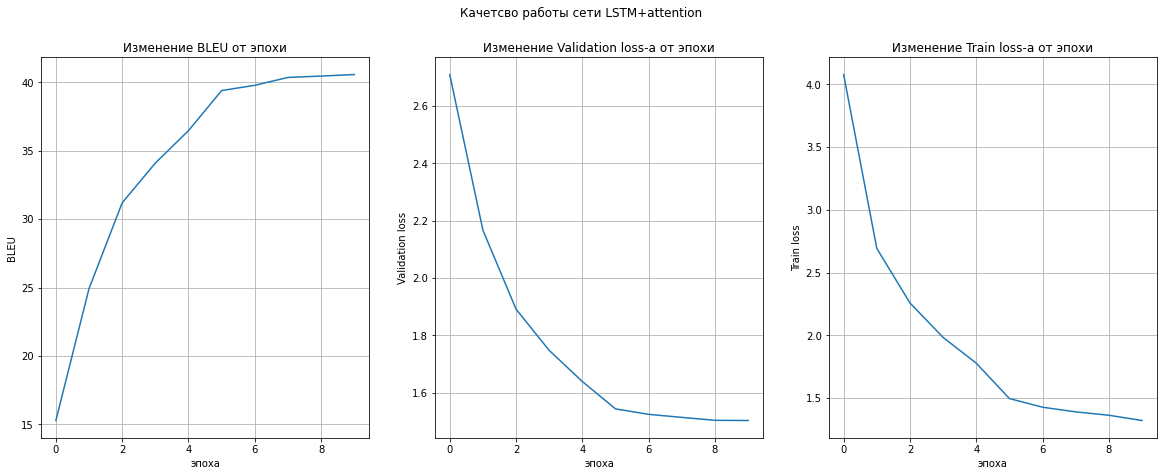

In [ ]:
with open(path_to_save_artifacts + '/model_results.pkl', 'rb') as f:
    history_dict = pickle.load(f)
bleu = history_dict['bleu']
train_losses = history_dict['train']
valid_losses = history_dict['valid']
fig, axs = plt.subplots(1,3, figsize = (20,7))
fig.suptitle('Качетсво работы сети LSTM+attention')
axs[0].set_title('Изменение BLEU от эпохи')
axs[0].set_xlabel('эпоха')
axs[0].set_ylabel('BLEU')
axs[0].grid()
axs[0].plot(range(len(bleu)), bleu)

axs[1].set_title('Изменение Validation loss-a от эпохи')
axs[1].set_xlabel('эпоха')
axs[1].set_ylabel('Validation loss')
axs[1].grid()
axs[1].plot(range(len(valid_losses)), valid_losses)

axs[2].set_title('Изменение Train loss-a от эпохи')
axs[2].set_xlabel('эпоха')
axs[2].set_ylabel('Train loss')
axs[2].grid()
axs[2].plot(range(len(train_losses)), train_losses)
plt.show();

# Краткий обзор

В данном случае это было интересное решение, так как включало в себя использование подхода из компьютерного зрения(сверточные слои), а такде помимо attention механизма, мы использовали информацию о позиции слова. Качество получилось лучше, чем у рекурентной сети. Заметного переобучения нет, лоссы на валидации и тесте совпадают.

### Метрики: 
train. Loss: 1.115 |  train. PPL:   3.049 | train. bleu: 47.18309369340316	

test. Loss: 1.467  |  test. PPL:   4.335  | test. bleu: 40.73896844656077

Val. Loss: 1.503   |  Val. PPL:   4.496   | val. bleu: 40.78187717111222

### Хорошие и плохие переводы преставлены выше.
### Графики обучения также предствалены выше.
### Скорость обучения:
1 минута на эпоху, где батч = 128, а треин корпус состоит из 40000 примеров
что намного быстрее, чем рекурентная сеть
### Cкорость инференса:

CPU times: user 40.2 ms, sys: 2.97 ms, total: 43.2 ms
Wall time: 52.5 ms

На батч из 32